In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline

In [5]:
sns.set_style("dark")
sns.set_context("talk")

# Data Analysis

In [35]:
data_path = '~/twitter-hate-speech-classifier-DFE-a845520(2).csv'

df = pd.read_csv(data_path, encoding='latin1')
df = df.rename(columns={'does_this_tweet_contain_hate_speech': 'label',  
                        'does_this_tweet_contain_hate_speech:confidence': 'confidence' })

mapping = {'The tweet is not offensive': 'Not offensive', 
           'The tweet uses offensive language but not hate speech': 'Offensive',
           'The tweet contains hate speech': 'Hate speech'
          }
df['label'] = df['label'].map(lambda x: mapping[x])

In [36]:
gold = df[df['_golden']].dropna(axis=1)
data = df[~df['_golden']].dropna(axis=1)

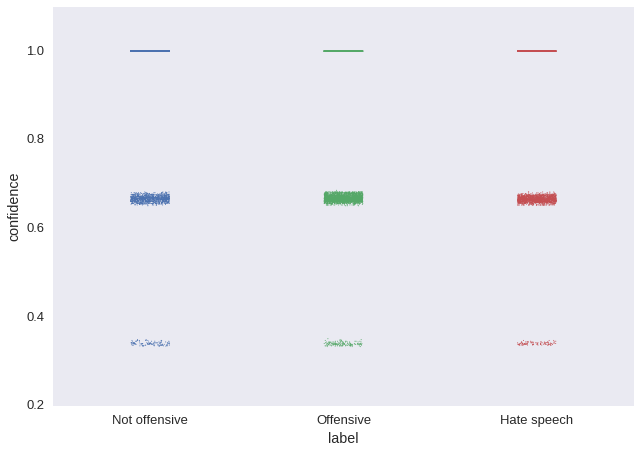

In [41]:
sns.stripplot(x="label", y="confidence", data=data, size=1, jitter=True);

In [42]:
data['label'].value_counts()

Not offensive    7253
Offensive        4807
Hate speech      2382
Name: label, dtype: int64

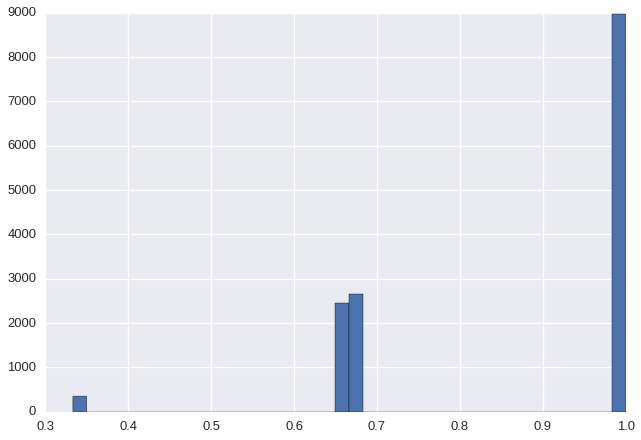

In [45]:
data['confidence'].hist(bins=40);

# Preprocessing

In [57]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_selection import SelectFromModel

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV

In [64]:
vectorizer = TfidfVectorizer(encoding='latin1', min_df=2)

X = vectorizer.fit_transform(data['tweet_text'])
y = data['label'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

In [65]:
X_train.shape

(12997, 8774)

### Dimentionality reduction

In [16]:
#pca = PCA(n_components=100)
#X_features = pca.fit_transform(X_train.toarray())

lsvc = LinearSVC(C=0.1, penalty="l1", dual=False).fit(X, y)
lsvc_select = SelectFromModel(lsvc, prefit=True)
X_train = lsvc_select.transform(X_train)
X_test = lsvc_select.transform(X_test)

### Training

In [ ]:
clf = SVC(class_weight='balanced')
clf.fit(X_train, y_train)

In [66]:
clf = LogisticRegression(class_weight='balanced')
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

### Grid Search

In [67]:
param_grid = [
  {'C': [1, 10, 100, 1000]}
]

clf = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid, cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'C': [1, 10, 100, 1000]}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

### Evaluation

In [68]:
preds = clf.predict(X_test)
print(classification_report(y_test, preds))

               precision    recall  f1-score   support

  Hate speech       0.52      0.49      0.51       238
Not offensive       0.88      0.95      0.91       726
    Offensive       0.68      0.62      0.65       481

  avg / total       0.75      0.76      0.76      1445



# Feature extraction

In [22]:
from textblob import TextBlob

In [25]:
text = 'this sucks'

In [26]:
blob = TextBlob(text)
blob.sentiment

Sentiment(polarity=-0.3, subjectivity=0.3)